In [1]:
from Model3 import RiverDeltaModel
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
import copy
import matplotlib.lines as mlines

c:\Users\sjuul\anaconda3\envs\afstuderen2025\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.simplefilter("ignore")

model = RiverDeltaModel()

initial_model_state = copy.deepcopy(model) 
for j in range(300):
    model.step()

There are 0 agents unassigned!!
agent niet gevonden
agent niet gevonden
agent niet gevonden
agent niet gevonden
agent niet gevonden
shock is happening!!
agent niet gevonden
shock is happening!!
agent niet gevonden
agent niet gevonden
agent niet gevonden
agent niet gevonden
agent niet gevonden
agent niet gevonden
agent niet gevonden


In [3]:
model_data = model.datacollector.get_model_vars_dataframe()
model_data

,Average_Livelihood,Num_household_members,Migrated_households,Migrated_members,Migrated_individuals,Died agents,Child births
0,0.376437,953,2,3,9,42,7
1,0.388901,919,6,22,10,63,14
2,0.381780,889,11,37,14,81,21
3,0.389118,867,12,40,23,103,33
4,0.390407,850,13,44,24,124,42
5,0.388069,847,15,48,24,131,50
6,0.389448,848,18,52,25,139,64
7,0.393412,835,18,52,32,149,68
8,0.390930,827,19,55,35,160,77
9,0.394164,830,19,55,37,164,86


In [4]:
agent_data = model.datacollector.get_agent_vars_dataframe()

agent_savings = agent_data[agent_data['Savings'].notna()]
agent_savings


Crop_type Land_category       Savings  too low income
Step AgentID                                                               
12   1002          Annual crops         small  1.050000e+07             NaN
     1003     Other agriculture         small  9.740951e+06             NaN
     1004          Annual crops         small  1.050000e+07             NaN
     1005          Annual crops         small  7.672491e+06             NaN
     1006          Annual crops         small  1.050000e+07             NaN
...                         ...           ...           ...             ...
300  1295                  None          None  4.765765e+09             0.0
     1297                  None          None  7.483020e+09             0.0
     1299                  None          None  9.691931e+09             0.0
     1300                  None          None  2.576285e+09             0.0
     1303                  None          None  5.122520e+09             0.0

[6461 rows x 4 columns]

In [5]:
agent_landless = agent_data[agent_data['too low income'].notna()]

agent_landless = agent_landless[agent_landless['too low income']==1]
agent_landless = agent_landless.reset_index()
agent_landless['Year'] = agent_landless['Step']//12

agent_landless = agent_landless.groupby('Year').size().reset_index(name="Too low income count")
agent_landless

,Year,Too low income count
0,1,3
1,3,2
2,4,3
3,5,1
4,6,2
5,7,1
6,8,4
7,9,3
8,10,2
9,11,2


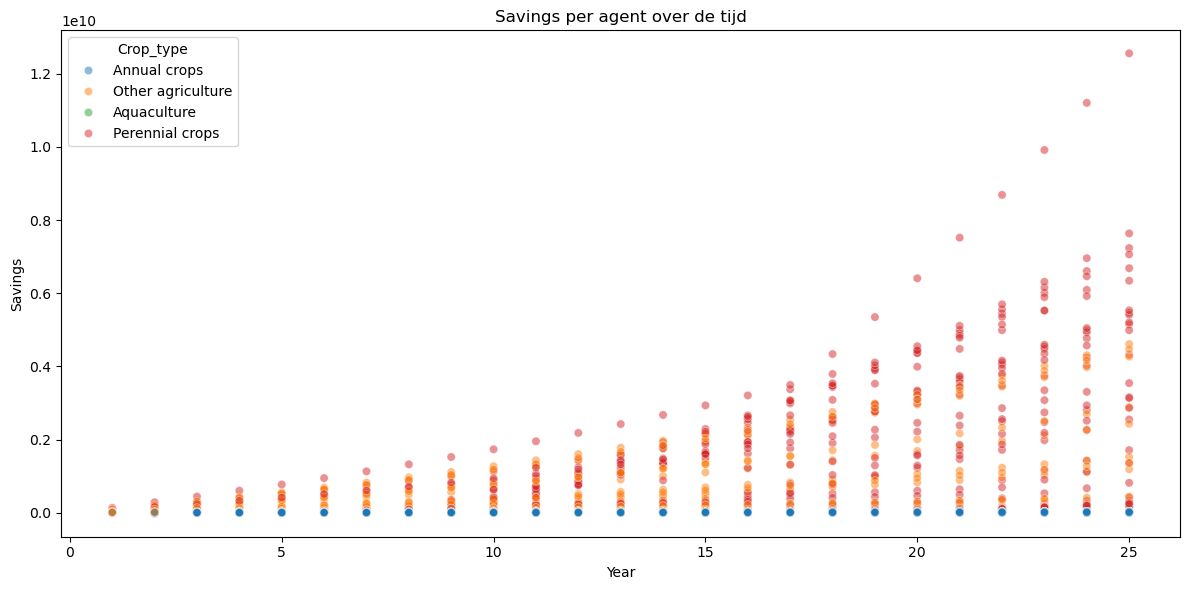

In [6]:
# agent_savings = agent_savings[agent_savings['Crop_type'].notna()]


agent_savings = agent_savings.reset_index()  # zodat 'Step' en 'AgentID' weer kolommen zijn
agent_savings['Year'] = agent_savings['Step'] / 12

import seaborn as sns
plt.figure(figsize=(12, 6))
sns.scatterplot(data=agent_savings, x='Year', y='Savings', hue='Crop_type', alpha=0.5)
plt.title("Savings per agent over de tijd")
plt.ylabel("Savings")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

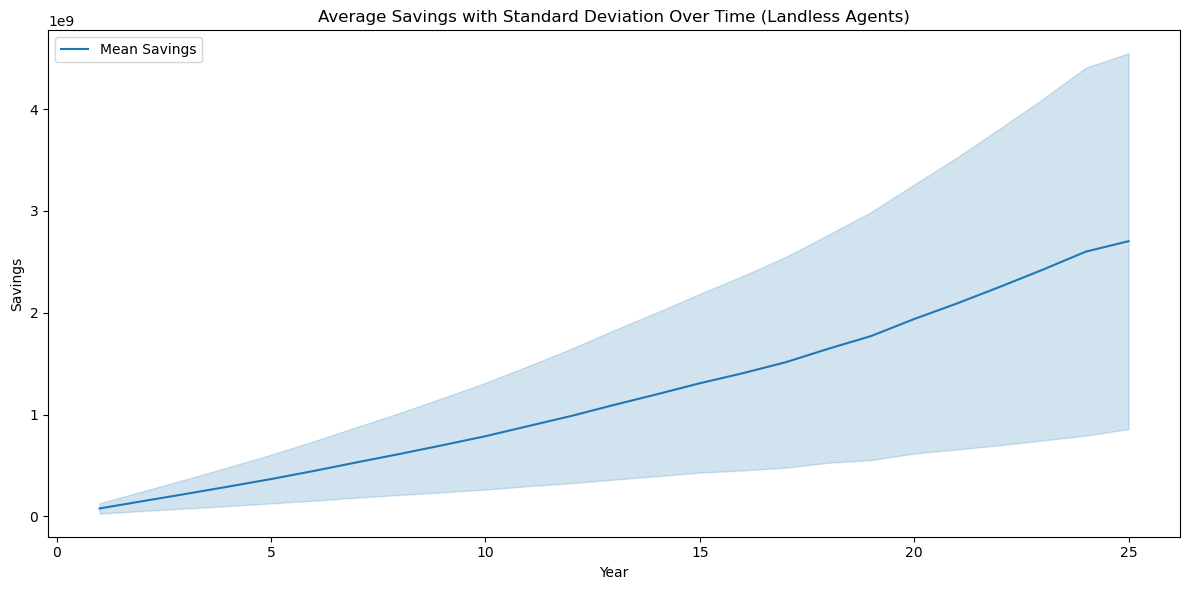

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter landless agents
landless_savings = agent_data[agent_data['too low income'].notna()].reset_index()
landless_savings['Year'] = landless_savings['Step'] / 12


# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=landless_savings,
    x="Year",
    y="Savings",
    errorbar='sd',  # std-deviation shaded area
    estimator="mean",
    label="Mean Savings",
    ci="sd"  # als je seaborn < 0.12 hebt, gebruik ci="sd"
)

plt.title("Average Savings with Standard Deviation Over Time (Landless Agents)")
plt.xlabel("Year")
plt.ylabel("Savings")
plt.tight_layout()
plt.show()



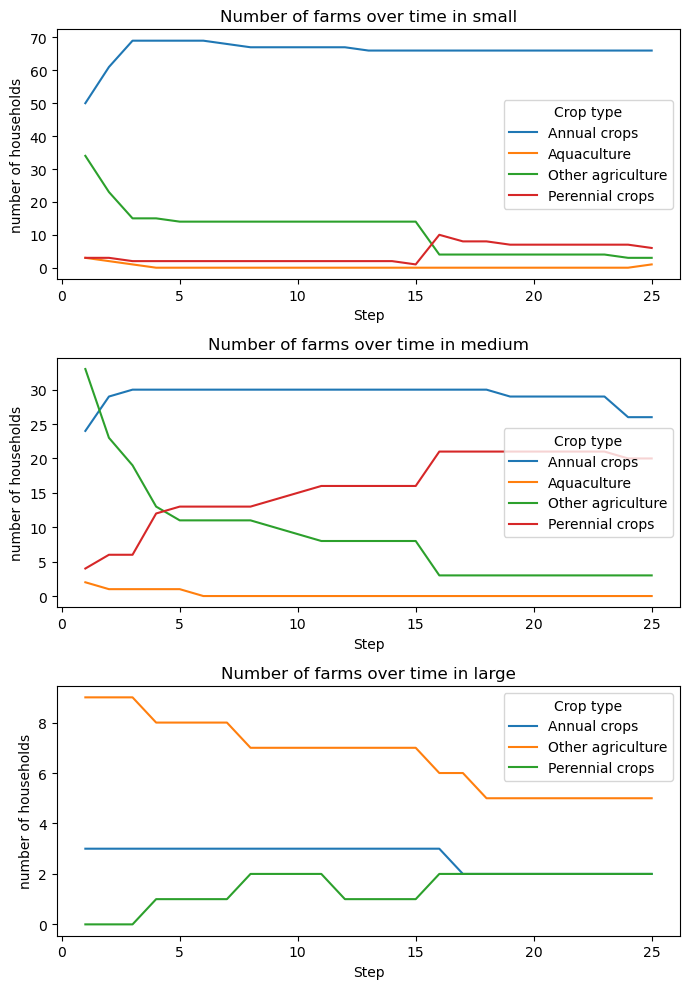

In [8]:
agent_data_crops_per_land = agent_data[agent_data['Crop_type'].notna()]
agent_data_crops_per_land

fig, axes = plt.subplots(nrows = 3, ncols= 1, figsize = (7,10))

for i, category in enumerate(['small', 'medium', 'large']):
    subsets = agent_data_crops_per_land[agent_data_crops_per_land["Land_category"]==category]
    subsets = subsets.reset_index()
    subsets = subsets.groupby(['Step', "Crop_type"]).size().reset_index(name = "count")
    subsets = subsets.pivot(index = "Step", columns = "Crop_type", values = "count").fillna(0)
    subsets.index = subsets.index / 12
    subsets.plot(ax=axes[i])
    axes[i].set_title(f"Number of farms over time in {category}")
    axes[i].set_ylabel("number of households")
    axes[i].legend(title = "Crop type")
    
plt.xlabel("Step")
plt.tight_layout()
plt.show()

# agent_data_crops_per_land = agent_data_crops_per_land.reset_index().groupby(['Step', "Crop_type", "Land_category"]).size().reset_index(name = "count")
# agent_data_crops_per_land.plot(kind="line", figsize = (10,6))
#
# plt.title("Crop type distribution over time")
# 

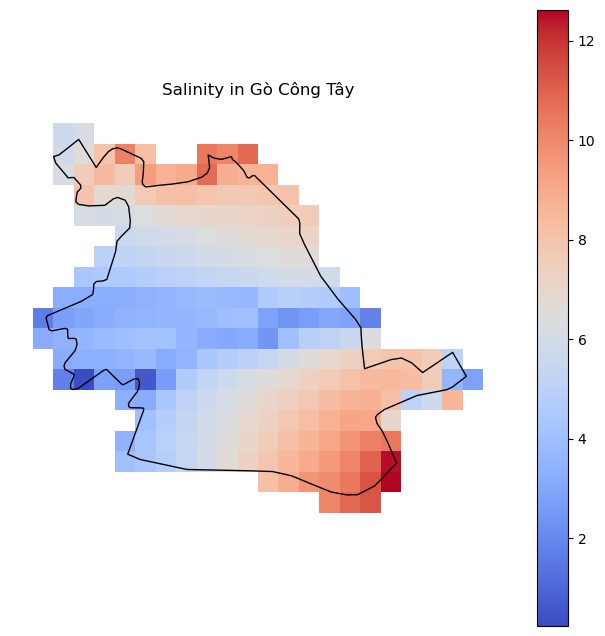

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
model.polygon_districts.boundary.plot(ax=ax, color='black', linewidth=1)
model.data_salinity.plot(ax=ax, column="Salinity", cmap="coolwarm", legend=True)
plt.title(f"Salinity in {model.district}")
plt.axis("off")
plt.show()

168
134


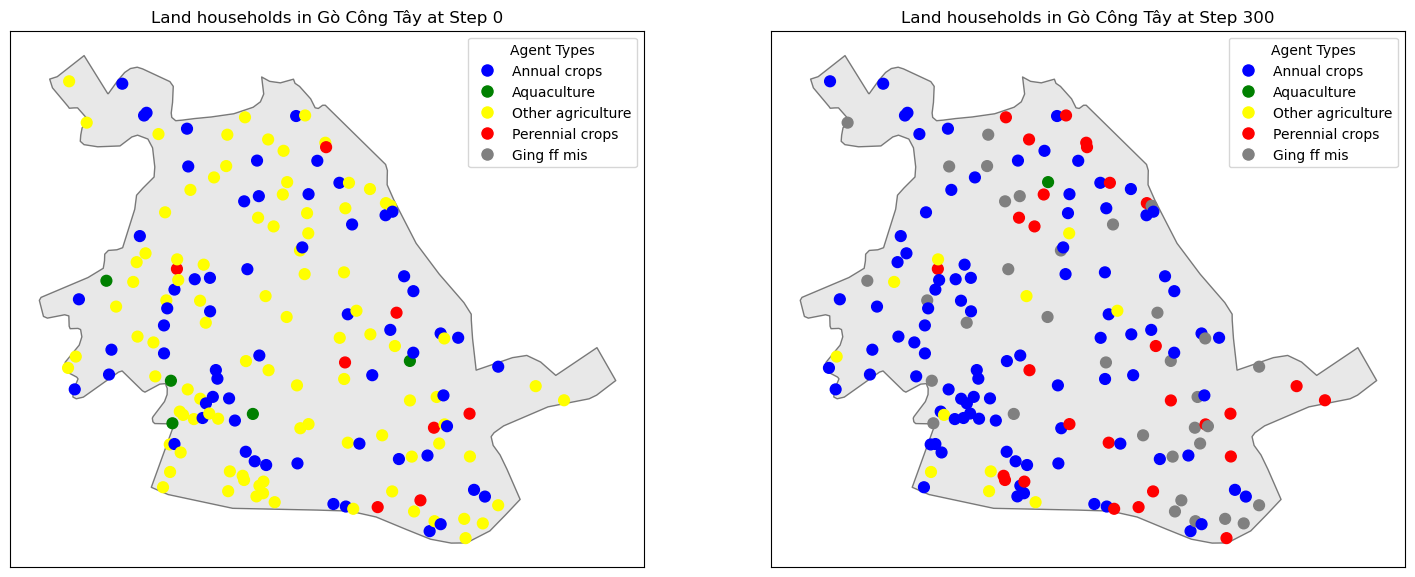

In [10]:
from Model3 import Large_land_households, Middle_land_households, Small_land_households

def plot_network(ax, model):
    ax.clear()

    # Plot district map
    model.polygon_districts.plot(ax=ax, facecolor="lightgray", edgecolor="black", alpha=0.5)

    # Get node positions
    pos = nx.get_node_attributes(model.G, 'pos')
    

    # Map node_id to agent
    node_to_agent = {agent.node_id: agent for agent in model.agents if isinstance(agent, (Large_land_households, Middle_land_households, Small_land_households))}
    print(len(node_to_agent))
    # Prepare lists for nodes and their colors
    nodes_to_draw = []
    colors_to_draw = []

    for node_id in model.G.nodes():
        nodes_to_draw.append(node_id)
        agent = node_to_agent.get(node_id)
        if agent:
            if agent.crop_type == "Annual crops":
                colors_to_draw.append('blue')
            elif agent.crop_type == "Aquaculture":
                colors_to_draw.append('green')
            elif agent.crop_type == "Other agriculture":
                colors_to_draw.append('yellow')
            elif agent.crop_type == "Perennial crops":
                colors_to_draw.append('red')
            else:
                colors_to_draw.append("gray")  # unknown crop
        else:
            colors_to_draw.append("gray")  # migrated / no agent

    # Draw edges first (optional)
    #nx.draw_networkx_edges(model.G, pos, ax=ax, edge_color="gray")

    # Draw nodes with matching colors
    nx.draw_networkx_nodes(model.G, pos,
                           nodelist=nodes_to_draw,
                           node_color=colors_to_draw,
                           node_size=60,
                           ax=ax)

    # Add legend
    blue_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Annual crops')
    green_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='green', markersize=10, label='Aquaculture')
    yellow_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Other agriculture')
    red_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='red', markersize=10, label='Perennial crops')
    grey_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Ging ff mis')
    ax.legend(handles=[blue_patch, green_patch, yellow_patch, red_patch, grey_patch], loc='upper right', title='Agent Types')

    ax.set_title(f"Land households in {model.district} at Step {model.steps}", fontsize=12)

    # Call function above to plot the map
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 9))
plot_network(ax1, initial_model_state)
plot_network(ax2, model)
plt.show()
